In [1]:
# import sys

# !{sys.executable} -m pip install \
#     pandas \
#     seaborn \
#     matplotlib \
#     numpy \
#     folium \
#     geopandas \
#     contextily \
#     shapely \
#     mapclassify \
#     descartes

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import folium
from folium.plugins import HeatMap
import geopandas as gpd
import contextily as ctx
from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely import wkt
import matplotlib.gridspec as gridspec
from scipy.stats import shapiro
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import DBSCAN

In [3]:
df = pd.read_csv("../data/katalog_gempa.csv")
df.head()

tgl            ot   lat     lon  depth  mag  \
0  2008/11/01  21:02:43.058 -9.18  119.06     10  4.9   
1  2008/11/01  20:58:50.248 -6.55  129.64     10  4.6   
2  2008/11/01  17:43:12.941 -7.01  106.63    121  3.7   
3  2008/11/01  16:24:14.755 -3.30  127.85     10  3.2   
4  2008/11/01  16:20:37.327 -6.41  129.54     70  4.3   

                     remark  
0  Sumba Region - Indonesia  
1                 Banda Sea  
2          Java - Indonesia  
3         Seram - Indonesia  
4                 Banda Sea

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92887 entries, 0 to 92886
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   tgl     92887 non-null  object 
 1   ot      92887 non-null  object 
 2   lat     92887 non-null  float64
 3   lon     92887 non-null  float64
 4   depth   92887 non-null  int64  
 5   mag     92887 non-null  float64
 6   remark  92887 non-null  object 
dtypes: float64(3), int64(1), object(3)
memory usage: 5.0+ MB


## data cleaning

In [5]:
df.isnull().sum()

tgl       0
ot        0
lat       0
lon       0
depth     0
mag       0
remark    0
dtype: int64

In [6]:
df.duplicated().sum()

np.int64(2735)

In [7]:
df.drop_duplicates(inplace=True)

df[df.duplicated()]

Empty DataFrame
Columns: [tgl, ot, lat, lon, depth, mag, remark]
Index: []

## visualisasi sebaran gempa

### heatmap

In [8]:
# Buat list data [lat, long, value] untuk heatmap
data_heatmap = df[['lat', 'lon', 'mag']].dropna().values.tolist()

# Buat peta dasar Indonesia
peta_indonesia = folium.Map(location=[-2.5, 118], zoom_start=5)

# Tambahkan heatmap ke peta
HeatMap(data_heatmap, radius=12, blur=15, max_zoom=6).add_to(peta_indonesia)

# Tampilkan peta
peta_indonesia

### basemap & grafik bar

In [9]:
# Tambahkan jitter ke koordinat lat dan lon agar tidak tumpang tindih
np.random.seed(42)  # supaya jitter selalu sama tiap run
long_jitter = df['lon'] + np.random.uniform(-0.05, 0.05, size=len(df))
lat_jitter = df['lat'] + np.random.uniform(-0.05, 0.05, size=len(df))

# Konversi DataFrame jadi GeoDataFrame dengan geometry titik
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(long_jitter, lat_jitter),
    crs='EPSG:4326'  # sistem koordinat GPS (WGS84)
)

# Proyeksikan ke Web Mercator
gdf = gdf.to_crs(epsg=3857)

# Contoh analisis: hitung rata-rata magnitude gempa per wilayah
mean_magnitude = df.groupby('remark')['mag'].mean()
top_5 = mean_magnitude.sort_values(ascending=False).head(5)
bottom_5 = mean_magnitude.sort_values().head(5)

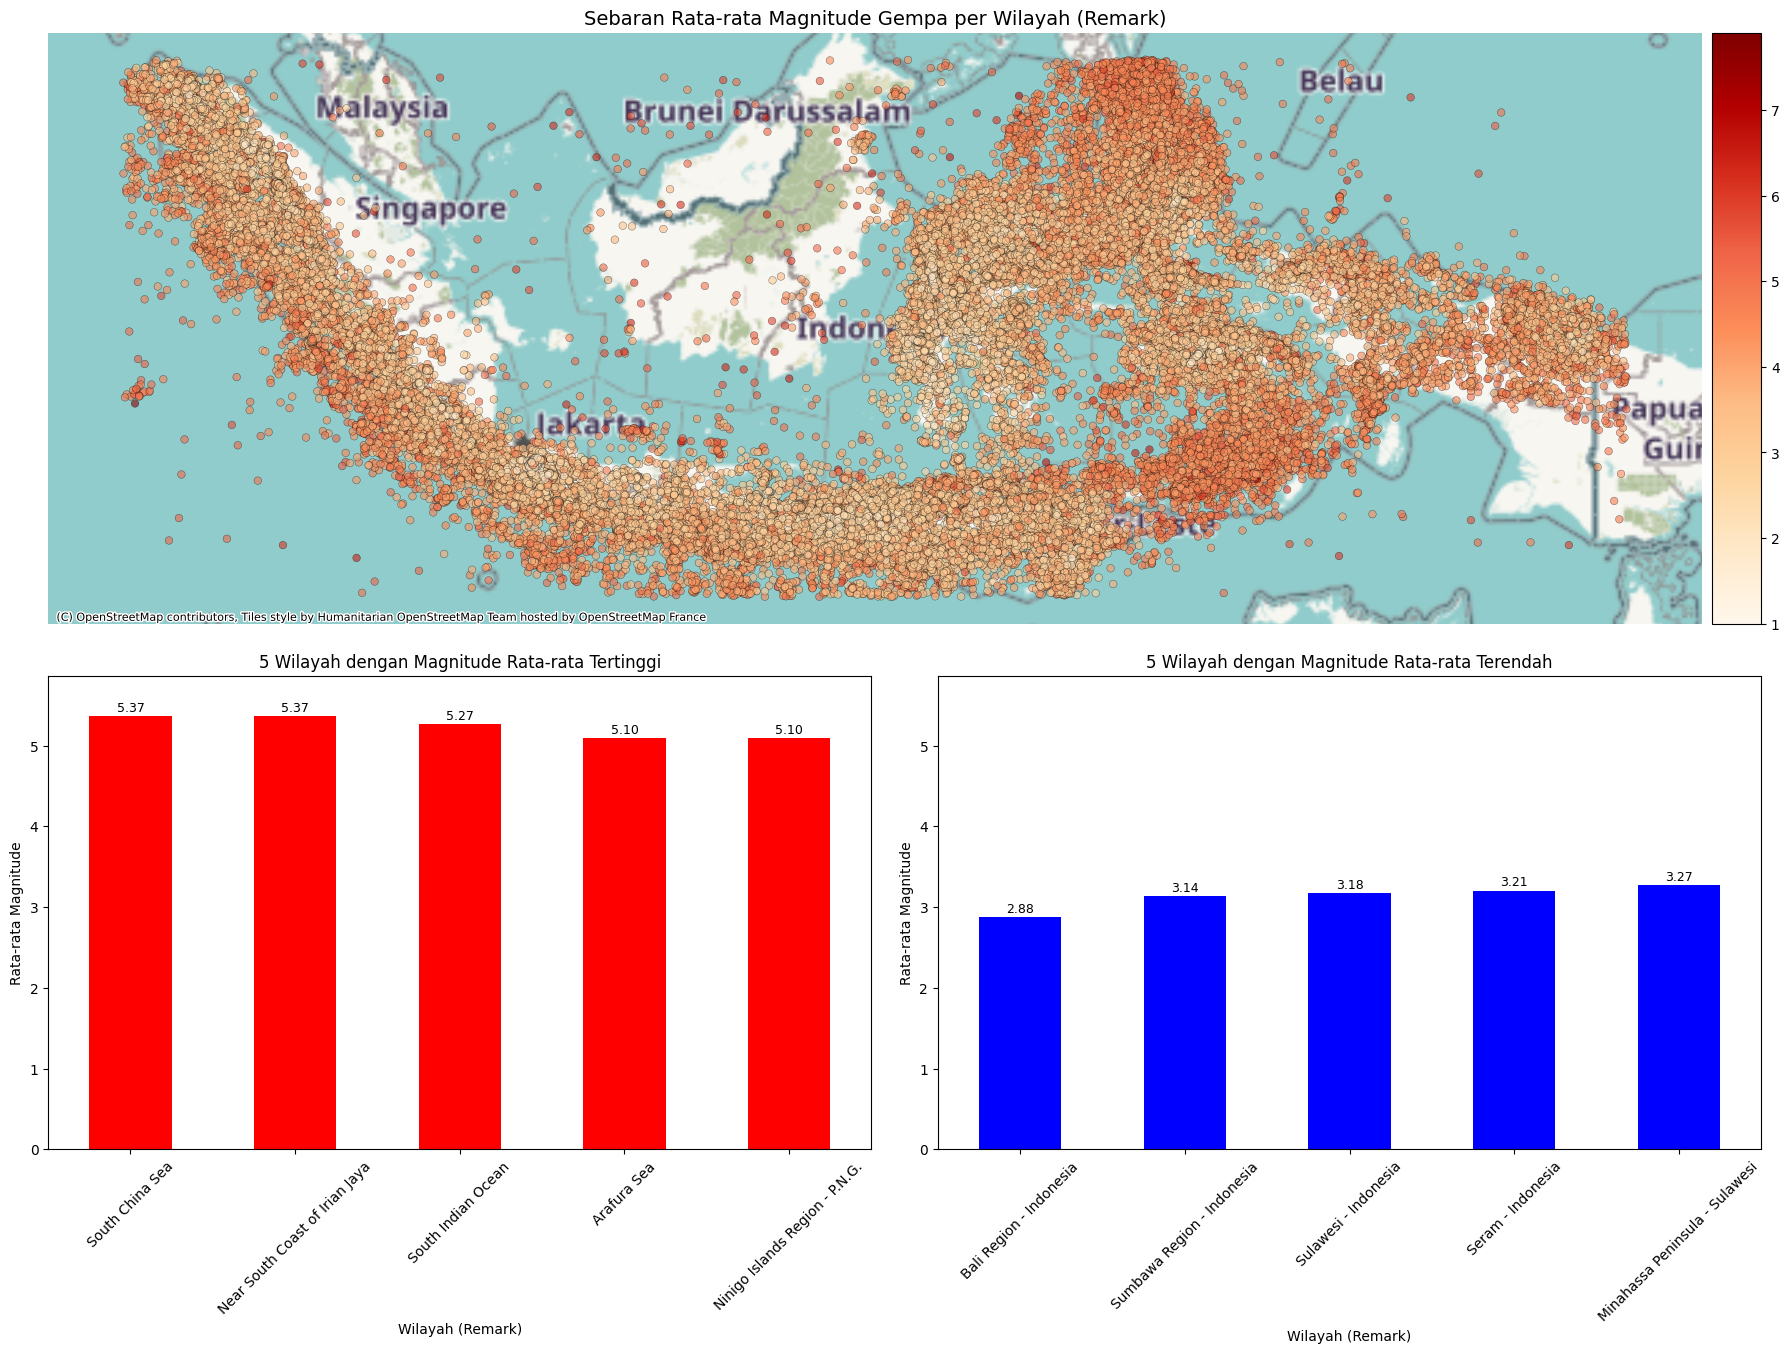

In [10]:
# Buat layout GridSpec (2 row, 2 col, peta colspan=2)
fig = plt.figure(figsize=(18, 14))
gs = gridspec.GridSpec(2, 2, height_ratios=[3, 2])

# --- Row 1: Peta sebaran (colspan=2) ---
ax_map = fig.add_subplot(gs[0, :])
divider = make_axes_locatable(ax_map)
cax = divider.append_axes("right", size="3%", pad=0.1)

# Plot peta sebaran dengan warna magnitude rata-rata per 'remark'
gdf.plot(
    ax=ax_map,
    column='mag',   # atau bisa gunakan 'remark' untuk warna kategorikal
    cmap='OrRd',
    legend=True,
    cax=cax,
    markersize=30,
    edgecolor='black',
    linewidth=0.3,
    alpha=0.6
)

# Tambahkan basemap
ctx.add_basemap(ax_map)

ax_map.set_title("Sebaran Rata-rata Magnitude Gempa per Wilayah (Remark)", fontsize=14)
ax_map.axis('off')

# --- Row 2: Bar chart top & bottom (vertikal stacked dalam satu kolom) ---
ax_top = fig.add_subplot(gs[1, 0])
ax_bottom = fig.add_subplot(gs[1, 1])

# Bar chart top 5 magnitude
bars_top = top_5.plot(kind='bar', ax=ax_top, color='red')
ax_top.set_title('5 Wilayah dengan Magnitude Rata-rata Tertinggi')
ax_top.set_ylabel('Rata-rata Magnitude')
ax_top.set_xlabel('Wilayah (Remark)')
ax_top.tick_params(axis='x', rotation=45)

# Bar chart bottom 5 magnitude
bars_bottom = bottom_5.plot(kind='bar', ax=ax_bottom, color='blue')
ax_bottom.set_title('5 Wilayah dengan Magnitude Rata-rata Terendah')
ax_bottom.set_ylabel('Rata-rata Magnitude')
ax_bottom.set_xlabel('Wilayah (Remark)')
ax_bottom.tick_params(axis='x', rotation=45)

# Tambah anotasi angka di atas bar
for ax, data in zip([ax_top, ax_bottom], [top_5, bottom_5]):
    for i, val in enumerate(data):
        ax.text(i, val + 0.02, f'{val:.2f}', ha='center', va='bottom', fontsize=9)

# Sinkronisasi skala Y kedua chart agar sama
max_val = max(top_5.max(), bottom_5.max())
for ax in [ax_top, ax_bottom]:
    ax.set_ylim(0, max_val + 0.5)

plt.tight_layout()
plt.show()

## normalisasi

In [11]:
# uji
normalityTest_df = df.drop(columns=['tgl', 'ot', 'remark'])
normalityTest_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 90152 entries, 0 to 92886
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   lat     90152 non-null  float64
 1   lon     90152 non-null  float64
 2   depth   90152 non-null  int64  
 3   mag     90152 non-null  float64
dtypes: float64(3), int64(1)
memory usage: 3.4 MB


In [12]:
stat, p = shapiro(normalityTest_df)

print("Statik: ", stat)
print("P-value: ", p)

if p > 0.05:
    print("Data berdistribusi normal (tidak tolak HO)")
else:
    print("Data tidak berdistribusi normal (tolak HO)")

Statik:  0.704751329490175
P-value:  9.783235845973618e-174
Data tidak berdistribusi normal (tolak HO)


C:\Users\LENOVO\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 360608.
  res = hypotest_fun_out(*samples, **kwds)


In [13]:
# normalisasi
normalisasi_df = df.drop(columns=['tgl', 'ot', 'remark'])

column_names = normalisasi_df.columns
scaler = RobustScaler()
normalisasi_df = scaler.fit_transform(normalisasi_df)
normalisasi_df = pd.DataFrame(normalisasi_df, columns=column_names)
normalisasi_df.head()

lat       lon     depth       mag
0 -0.779851 -0.156087 -0.119048  1.272727
1 -0.452736  0.634055 -0.119048  1.000000
2 -0.509950 -1.084391  2.523810  0.181818
3 -0.048507  0.500373 -0.119048 -0.272727
4 -0.435323  0.626587  1.309524  0.727273

## menentukan parameter epsilon menggunakan K-Distance Graph

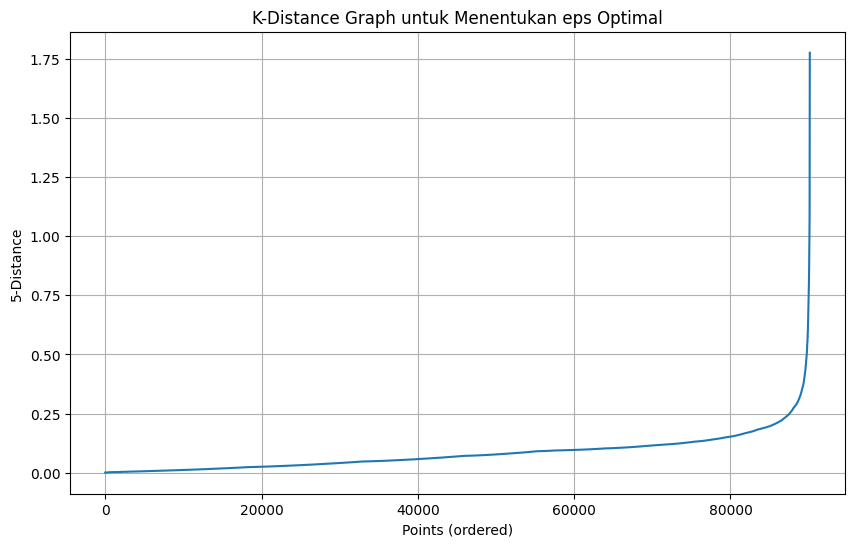

In [14]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

# Gunakan data hasil normalisasi
X = normalisasi_df.values

# Tentukan jumlah tetangga (min_samples biasanya = 4-10)
k = 5

# Fit nearest neighbors
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors (X)

#Ambil jarak tetangga ke-k (k-distance)
k_distances = np.sort(distances [:, k-1])

# Plot k-distance graph
plt.figure(figsize=(10, 6))
plt.plot(k_distances)
plt.title("K-Distance Graph untuk Menentukan eps Optimal")
plt.ylabel(f"{k}-Distance")
plt.xlabel("Points (ordered)")
plt.grid(True)
plt.show()

## DBSCAN clustering

In [19]:
dbscan = DBSCAN(eps=0.27, min_samples=15, algorithm="ball_tree")
labels = dbscan.fit_predict(normalisasi_df.values)

df["Cluster_DBSCAN"] = labels
print(df["Cluster_DBSCAN"].value_counts())

Cluster_DBSCAN
 0    86648
-1     3194
 1      126
 2       83
 3       75
 4       15
 5       11
Name: count, dtype: int64


## evaluasi kualitas clustering menggunakan silhouette score

In [20]:
from sklearn.metrics import silhouette_score

mask = labels != -1 # hilangkan noise
score = silhouette_score(normalisasi_df[mask], labels[mask])

print("Silhouette Score:", score)

Silhouette Score: 0.62846893292129


## visualisasi hasil clustering dengan PCA (2D)

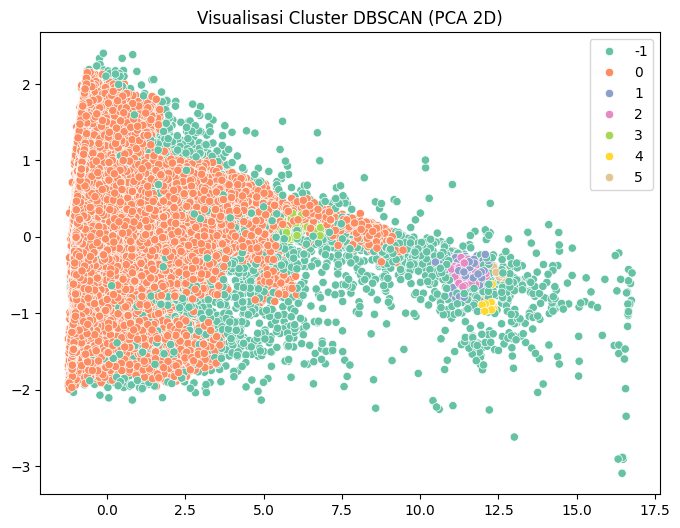

In [21]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced = pca.fit_transform (normalisasi_df)

plt.figure(figsize=(8,6))
sns.scatterplot(x=reduced[:,0], y=reduced[:, 1], hue=labels, palette="Set2")
plt.title("Visualisasi Cluster DBSCAN (PCA 2D)")
plt.show()

## pengelompokan kualitatif cluster

In [23]:
def klasifikasi_db(x):
    if x == 0:
        return "Baik"
    elif x == -1:
        return "Noise"
    else:
        return "Kurang"

df['Klasifikasi_DBSCAN'] = df['Cluster_DBSCAN'].apply(klasifikasi_db)
print(df[ 'Klasifikasi_DBSCAN'].value_counts())

Klasifikasi_DBSCAN
Baik      86648
Noise      3194
Kurang      310
Name: count, dtype: int64


## analisis lanjutan per cluster (Cluster Summary)

In [26]:
cluster_summary_db = df.drop(columns=['tgl', 'ot', 'remark']).groupby('Klasifikasi_DBSCAN').mean()
cluster_summary_db

lat         lon       depth       mag  Cluster_DBSCAN
Klasifikasi_DBSCAN                                                            
Baik               -3.437643  119.203353   40.281080  3.517722         0.00000
Kurang             -1.366484  123.797677  477.709677  4.383548         2.03871
Noise              -2.922940  117.969101  226.593926  4.356700        -1.00000